In [2]:
import numpy as np
import scipy as sp
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import patches

N = 100 
b = 0.95 # бета
t = 10 # тета

In [3]:
def cdf_inverse(Fx, theta = t):
    return ((Fx+1) * theta).astype(float)

def generate_sample(n = N, theta = t, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    Fx = np.random.sample(n)
    return cdf_inverse(Fx, theta)

sample = generate_sample(random_state=42)
sample

array([13.74540119, 19.50714306, 17.31993942, 15.98658484, 11.5601864 ,
       11.5599452 , 10.58083612, 18.66176146, 16.01115012, 17.08072578,
       10.20584494, 19.69909852, 18.32442641, 12.12339111, 11.81824967,
       11.8340451 , 13.04242243, 15.24756432, 14.31945019, 12.9122914 ,
       16.11852895, 11.39493861, 12.92144649, 13.66361843, 14.56069984,
       17.85175961, 11.99673782, 15.14234438, 15.92414569, 10.46450413,
       16.07544852, 11.70524124, 10.65051593, 19.48885537, 19.65632033,
       18.08397348, 13.04613769, 10.97672114, 16.84233027, 14.40152494,
       11.22038235, 14.9517691 , 10.34388521, 19.09320402, 12.58779982,
       16.62522284, 13.11711076, 15.20068021, 15.46710279, 11.84854456,
       19.69584628, 17.75132823, 19.39498942, 18.9482735 , 15.97899979,
       19.21874235, 10.88492502, 11.95982862, 10.45227289, 13.25330331,
       13.8867729 , 12.71349032, 18.28737509, 13.56753327, 12.8093451 ,
       15.42696083, 11.40924225, 18.02196981, 10.74550644, 19.86

In [4]:
def exact_confidence_interval(sample, beta = b, precision = 3):
    x_max = np.max(sample)
    t1 = x_max / (((1 + beta)/2) ** (1/np.size(sample)) + 1)
    t2 = x_max / (((1 - beta)/2) ** (1/np.size(sample)) + 1)
    return round(t1, precision), round(t2, precision)

t1, t2 = exact_confidence_interval(sample)
print(f'интервал ({t1}, {t2})')

intervals = []
intervals.append((t1, t2))

интервал (9.936, 10.118)


In [5]:
def calc_quantiles(beta):
    erfinv = sp.special.erfinv
    u1 = 2**0.5 * erfinv(-beta)
    u2 = -u1
    return u1, u2

def asymptotic_confidence_interval(sample, beta=b, precision=3):
    n = np.size(sample)
    mean = np.mean(sample)
    square_mean = np.dot(sample, sample) / n
    
    u1, u2 = calc_quantiles(beta)
    t1 = 3/2 * u1 * ((square_mean-mean**2)/n)**0.5 + 2/3*mean
    t2 = 3/2 * u2 * ((square_mean-mean**2)/n)**0.5 + 2/3*mean
    return round(t1, precision), round(t2, precision)


t1, t2 = asymptotic_confidence_interval(sample)
print(f'интервал ({t1}, {t2})')

intervals.append((t1, t2))

интервал (8.931, 10.671)


In [6]:
def est_1(sample):
    mean = np.mean(sample)
    return 2/3 * mean

def est_2(sample):    
    n = np.size(sample)
    x_max = np.max(sample)
    return (n+1)/(2*n+1) * x_max

n_est = np.array([est_1, est_2])

print('Оценки: тета1=', est_1(sample), 'тета_2=', est_2(sample))

Оценки: тета1= 9.80120495585473 тета_2= 9.983859731176729


In [7]:
def bootstrap_confidence_interval(sample, estimation, beta=b, BOOTSTRAP_RANGE=1000, precision=3):
    theta_est = estimation(sample)
    deltas = []
    for i in range(BOOTSTRAP_RANGE):
        sample_i = np.random.choice(sample, size=np.size(sample))
        deltas.append(estimation(sample_i) - theta_est)
    k1 = int((1 - beta)/2 * BOOTSTRAP_RANGE) - 1
    k2 = int((1 + beta)/2 * BOOTSTRAP_RANGE) - 1
    deltas = np.sort(deltas)
    t1 = -deltas[k2] + theta_est
    t2 = -deltas[k1] + theta_est
    return round(t1, precision), round(t2, precision)

intervals_ = [bootstrap_confidence_interval(sample, est_1), bootstrap_confidence_interval(sample, est_2)]
print('Bootstrap:', intervals_)

intervals.extend(intervals_)

Bootstrap: [(9.407, 10.177), (9.984, 10.091)]


In [8]:
def bootstrap_with_parameter_confidence_interval(sample, estimation, beta=b, BOOTSTRAP_RANGE=10_000, precision=3):
    theta_est = estimation(sample)
    thetas = []
    for i in range(BOOTSTRAP_RANGE):
        sample_i = generate_sample(theta=theta_est)
        thetas.append(estimation(sample_i))
    thetas = np.sort(thetas)
    k1 = int((1-beta)/2 * BOOTSTRAP_RANGE) - 1
    k2 = int((1+beta)/2 * BOOTSTRAP_RANGE) - 1
    t1 = thetas[k1]
    t2 = thetas[k2]
    return round(t1, precision), round(t2, precision)
    
    
intervals_ = [bootstrap_with_parameter_confidence_interval(sample, est_1, BOOTSTRAP_RANGE = 50_000), bootstrap_with_parameter_confidence_interval(sample, est_2, BOOTSTRAP_RANGE = 50_000)]
print('Bootstrap с параметром:', intervals_)

intervals.extend(intervals_)

Bootstrap с параметром: [(9.431, 10.169), (9.854, 10.032)]


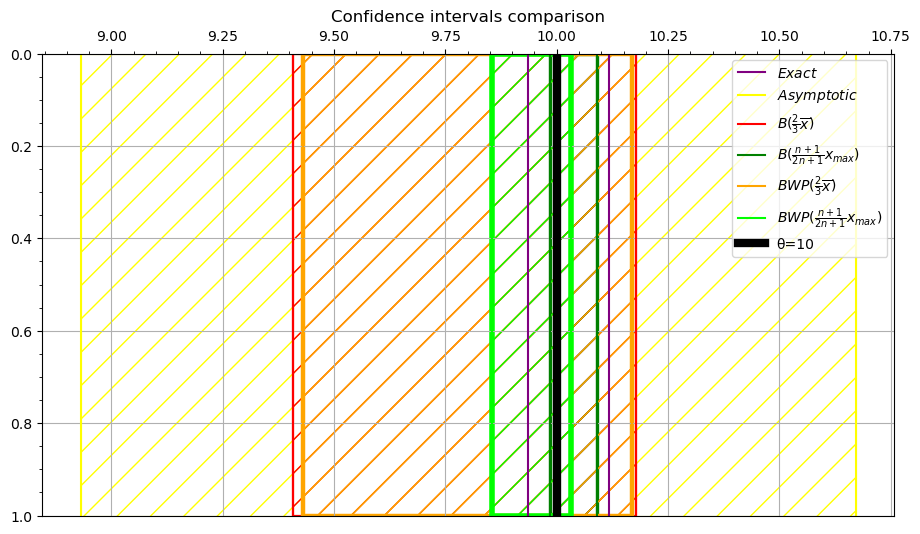

In [9]:
fig, ax = plt.subplots(figsize=(11, 6))

y_min, y_max = 0, 1

plt.title('Сравнение доверительных интервалов')
plt.ylim(y_min, y_max)
ax.minorticks_on()
ax.grid(which='major')

colors = ['purple', 'yellow', 'red', 'green', 'orange', 'lime']
n_est_formula = [r'\frac{2}{3}\overline{x}', r'\frac{n+1}{2n+1}x_{max}']
labels = ['Exact', 'Asymptotic'] + [f'B({formula})' for formula in n_est_formula] + [f'BWP({formula})' for formula in n_est_formula]
labels += [f'θ={t}']
min_width, max_width = 0, 4
linewidths = np.linspace(min_width, max_width, len(intervals))

y = [y_min, y_max]

for i, interv in enumerate(intervals):
    xi1 = [interv[0], interv[0]]
    xi2 = [interv[1], interv[1]]
    ax.plot(xi1, y, color=colors[i], label=fr'${labels[i]}$')
    ax.plot(xi2, y, color=colors[i])
    patch = patches.Rectangle((xi1[0], y[0]), xi2[0]-xi1[0], y[1], linewidth=linewidths[i], fill=None, hatch='/', color=colors[i])
    ax.add_patch(patch)

ax.plot((t, t), y, color='black', label=labels[-1], linewidth=max_width*1.5)

plt.gca().invert_yaxis()
plt.gca().axes.xaxis.set_ticks_position("top")
plt.legend()

fig1 = plt.gcf()
plt.show()

fig1.savefig('', dpi=120)